# Main imports

### Native imports

In [33]:
import os
import pandas as pd
from datetime import date, datetime

### More imports

In [34]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from keras.layers.normalization import batch_normalization

from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load imatge classification

En un futur seria interesant crear una llibreria propia per a manejar les dades i poder agafar mostres en concret. En aquest cas estic agafant la part de validation perque conte totes les cares d'una mateix persona i per a fer proves i entrenar la xarxa és més ràpid.

In [35]:
identity_df = pd.read_csv("Imatges\CelebA\Anno\identity_CelebA.txt", sep=' ', header=None)
list_eval_partition_df = pd.read_csv("Imatges\CelebA\Eval\list_eval_partition.txt", sep=' ', header=None)
identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
list_eval_partition_df = list_eval_partition_df.rename(columns={0:"Image_name", 1:"Evaluation_status"})
identity_df = identity_df.merge(list_eval_partition_df, how="outer", on='Image_name')

## Process data

In [36]:
print(identity_df.head())
print(identity_df.shape)
print(f"Numero de persones: {identity_df['Identity'].nunique()}")

   Image_name  Identity  Evaluation_status
0  000001.jpg      2880                  0
1  000002.jpg      2937                  0
2  000003.jpg      8692                  0
3  000004.jpg      5805                  0
4  000005.jpg      9295                  0
(202599, 3)
Numero de persones: 10177


In [37]:
TARGET = 3227

In [38]:
identity_df["target"] = identity_df["Identity"] == TARGET
identity_df["target"] = identity_df["target"].astype(str)

### Training, validation and test dataframes

In [39]:
train_df = identity_df[identity_df["Evaluation_status"] == 0][["target","Image_name"]]
val_df = identity_df[identity_df["Evaluation_status"] == 1][["target","Image_name", "Identity"]]
test_df = identity_df[identity_df["Evaluation_status"] == 2][["target","Image_name"]]

### Cleaning data

In [40]:
train_df = train_df.iloc[:161679]
val_df = val_df.loc[163291:181835]
val_df = val_df[~val_df["Identity"].isin([1642, 1807, 1625, 1934, 3140, 1519, 2496, 1542, 1164, 2973, 1440, 1908, 2195, 2303, 499, 4388, 3113, 3255, 981])]
val_df = shuffle(val_df)
val_df.reset_index(inplace=True)
val_df
print(val_df["target"].value_counts())

False    17940
True        35
Name: target, dtype: int64


In [41]:
def print_params_tvt(train_df, val_df, test_df):
    print(f"Train len: {len(train_df)}")
    print(train_df["target"].nunique())
    print(f"Val len: {len(val_df)}")
    print(val_df["target"].nunique())
    print(f"Test len: {len(test_df)}")
    print(test_df["target"].nunique())

Train len: 161679
1
Val len: 17975
2
Test len: 19962
1


In [ ]:
print_params_tvt(train_df, val_df, test_df)

In [42]:
train = val_df.iloc[:-2980*2]
val = val_df.iloc[-2980*2:-2980]
test = val_df.iloc[-2980:]
print_params_tvt(train, val, test)

In [43]:
img_dir = "Imatges/CelebA/Img/img_align_celeba/img_align_celeba/"
img_size = (178,218)
batch_size = 100
epochs = 25

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [45]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_dir,
    x_col="Image_name",
    y_col="target",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary")

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=val,
    directory=img_dir,
    x_col="Image_name",
    y_col="target",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary")

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=img_dir,
    x_col="Image_name",
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=True,
)

Found 12015 validated image filenames belonging to 2 classes.
Found 2980 validated image filenames belonging to 2 classes.
Found 2980 validated image filenames.


In [46]:
# Xarxa neuronal random
# Els kernels han de pujar a mesura que anem afegint layers
def prepare_model1():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(178, 218, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

In [47]:
# https://github.com/hlamba28/Offline-Signature-Verification-using-Siamese-Network/blob/master/SigNet-BHSig260.ipynb
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/weights_epoch_{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [48]:
model = prepare_model1()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 176, 216, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 88, 108, 32)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 304128)            0         
                                                                 
 dense_3 (Dense)             (None, 50)                15206450  
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                      

In [51]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    callbacks = callbacks)


Epoch 1/25
120/120 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9982
Epoch 1: saving model to ./Weights\weights_epoch_001.h5
120/120 [==============================] - 213s 2s/step - loss: 0.0147 - accuracy: 0.9982 - val_loss: 0.0172 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9982
Epoch 2: saving model to ./Weights\weights_epoch_002.h5
120/120 [==============================] - 238s 2s/step - loss: 0.0127 - accuracy: 0.9982 - val_loss: 0.0162 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9982
Epoch 3: saving model to ./Weights\weights_epoch_003.h5
120/120 [==============================] - 282s 2s/step - loss: 0.0133 - accuracy: 0.9982 - val_loss: 0.0175 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 4/25
120/120 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9982
Epoch 4: savi

In [52]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 31s 1s/step - loss: 0.0177 - accuracy: 0.9977
Test loss: 0.0176960788667202
Test accuracy: 0.9976509809494019


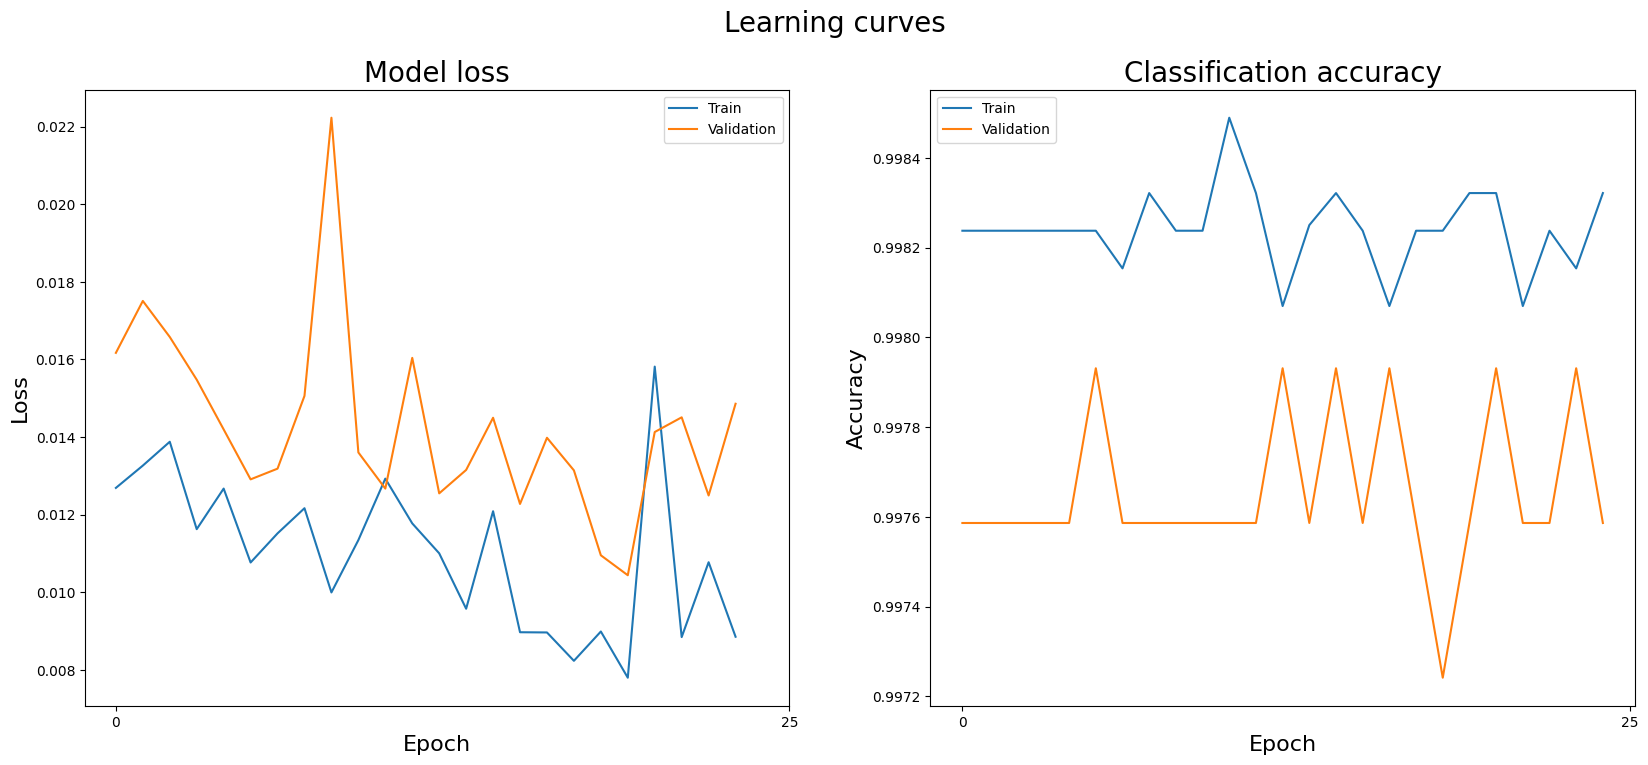

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'][1:])
ax1.plot(history.history['val_loss'][1:])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, epochs+1, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Classification accuracy', size=20)
ax2.set_ylabel('Accuracy', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, epochs+1, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()